# Problemset 3 1/24/18

## Dr. Rick Evans MACS 30100

### Kristopher Nichols

#### 1a: Plot Histogram

In [142]:
import matplotlib
import matplotlib.pyplot as plt
import numpy.linalg as lin
import scipy.stats as sts
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
import scipy.integrate as intgr
import scipy.optimize as opt
income_macss = np.loadtxt('incomes.txt')

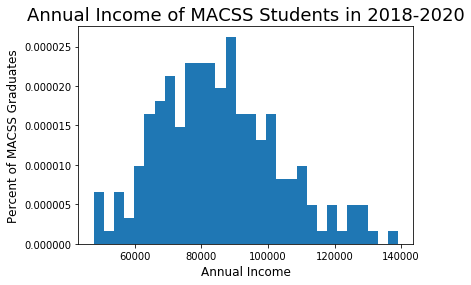

In [143]:
# Plot histogram of income data
plt.hist(income_macss, bins = 30, normed = True)
plt.title('Annual Income of MACSS Students in 2018-2020',
             fontsize=18)
plt.ylabel('Percent of MACSS Graduates', fontsize=12)
plt.xlabel('Annual Income', fontsize=12)
plt.show()

#### 1b: Estimate parameters of lognormal distribution by GMM

Define Moments and Criterion

In [144]:
# Define components necessary for GMM
def trunc_lognorm_pdf(xvals, mu, sigma, cutoff):
    if cutoff == 'None':
        prob_notcut = 1.0
    else:
        prob_notcut = sts.norm.cdf(cutoff, loc=mu, scale=sigma)
    lognorm_pdf_vals = ((1/(xvals*sigma * np.sqrt(2 * np.pi)) *
                    np.exp( - (np.log(xvals) - mu)**2 / (2 * sigma**2))) /
                    prob_notcut)
    return lognorm_pdf_vals


def data_moments(xvals):
    mean_data = xvals.mean()
    std_data = xvals.std()
    return mean_data, std_data


def model_moments(mu, sigma, cutoff):
    xfx = lambda x: x * trunc_lognorm_pdf(x, mu, sigma, cutoff)
    (mean_model, m_m_err) = intgr.quad(xfx, 0.00001, cutoff) 
    x2fx = lambda x: ((x - mean_model) ** 2) * trunc_lognorm_pdf(x, mu, sigma, cutoff) 
    (var_model, v_m_err) = intgr.quad(x2fx, .00001, cutoff)
    std_model = np.sqrt(var_model)
    s_m_err = np.sqrt(v_m_err)
    return mean_model, std_model

def err_vec(xvals, mu, sigma, cutoff, simple):
    mean_data, std_data = data_moments(xvals)
    moms_data = np.array([[mean_data], [std_data]])
    mean_model, std_model = model_moments(mu, sigma, cutoff)
    moms_model = np.array([[mean_model], [std_model]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    return err_vec



def criterion(params, *args):
    mu, sigma = params
    xvals, cutoff, W = args
    err = err_vec(xvals, mu, sigma, cutoff, simple=False)
    crit_val = np.dot(np.dot(err.T, W), err) 
    return crit_val


mu_init = 11
sig_init = 0.5
inc_sim = np.linspace(0.000001, 150000, 200)

Estimate Parameters 1B

In [145]:
# Establish GMM and Weight
params_init = np.array([mu_GMM1, sig_GMM1])
GMM1_Value = criterion(params_init, *gmm_args)[0][0]
W_hat = np.eye(2)

gmm_args = (income_macss, 150000, W_hat)
results = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))


mu_GMM1, sig_GMM1 = results.x
print('mu_GMM1=', mu_GMM1, ' sig_GMM1=', sig_GMM1, "criterion value=", GMM1_Value)

mu_GMM1= 11.3369101389  sig_GMM1= 0.213027109548 criterion value= 3.66308283319e-14


Graph 1B

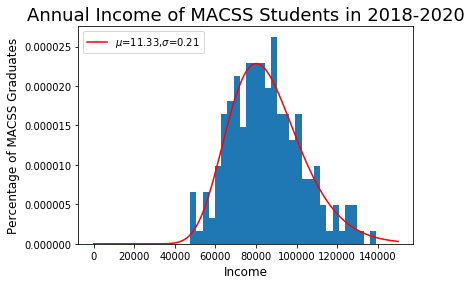

In [146]:
# Plot
num_bins = 30 
plt.hist(income_macss, num_bins, normed = True)
plt.ylabel("Percentage of MACSS Graduates", fontsize=12)
plt.xlabel("Annual Income", fontsize=12)
plt.title("Annual Income of MACSS Students in 2018-2020", fontsize=18)
plt.plot(inc_sim, trunc_lognorm_pdf(inc_sim, mu_GMM1, sig_GMM1, 150000), color = 'r', label = '$\mu$=11.33,$\sigma$=0.21')
plt.legend(loc = 'upper left')
plt.show()

#### 1C

Estimate Parameters 1C

In [147]:
err1 = err_vec(inc_sim, mu_GMM1, sig_GMM1, 150000, False)
VCV2 = np.dot(err1, err1.T) / inc_sim.shape[0]
W_hat2 = lin.pinv(VCV2)

params_init1 = np.array([mu_GMM1, sig_GMM1])
gmm_args2 = (income_macss, 150000, W_hat2)
results2 = opt.minimize(criterion, params_init1, args=(gmm_args2),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM2, sig_GMM2 = results2.x


params_GMM2 = np.array([mu_GMM2, sig_GMM2])
GMM2_Value = criterion(params_GMM2, *gmm_args2)[0][0]

mean_data, std_data = data_moments(income_macss)
mean_model2, std_model2 = model_moments(mu_GMM2, sig_GMM2, 150000)

print("")
print('mu_GMM2=', mu_GMM2, ' sig_GMM2=', sig_GMM2, "criterion value:", GMM2_Value)
print('mean of data: {:.5f}, standard deviation of data {:.5f}'.format(mean_data,std_data))
print('mean of model: {:.5f}, standard deviation of data {:.5f}'.format(mean_model2,std_model2))


mu_GMM2= 11.3369101378  sig_GMM2= 0.21302709675 criterion value: 2.2202053217e-13
mean of data: 85276.82361, standard deviation of data 17992.54213
mean of model: 85276.80726, standard deviation of data 17992.54095


Graph 1C

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in multiply
  


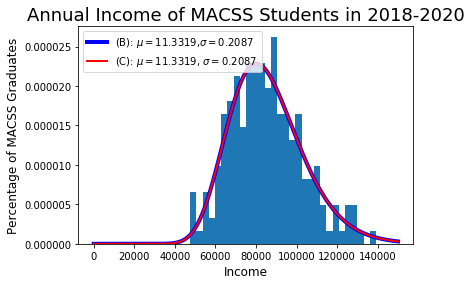

In [148]:
num_bins = 30 

plt.hist(income_macss, num_bins, normed = True)
plt.title('Annual Income of MACSS Students in 2018-2020', fontsize=18)
plt.xlabel('Annual Income', fontsize=12)
plt.ylabel('Percentage of MACSS Graduates', fontsize=12)


dist_income = np.linspace(lower_bound, upper_bound, nums)
plt.plot(dist_income, trunc_lognorm_pdf(dist_income, mu_GMM1, sig_GMM1, 150000),
         linewidth=4, color='blue', label='(B): $\mu = 11.3319$,$\sigma = 0.2087$')

plt.plot(dist_income, trunc_lognorm_pdf(dist_income, mu_GMM2, sig_GMM2, 150000),
         linewidth=2, color='r', label='(C): $\mu = 11.3319$, $\sigma = 0.2087$')
plt.legend(loc='upper left')
plt.show()



#### 1D

Estimate Parameters 1D

In [149]:
mu_init = 11.0
sig_init = 0.5

# Establish bounds and incorporate 3rd moment
def data_moments3(xvals):
    bpct_1_dat = xvals[xvals < 75000].shape[0] / xvals.shape[0]
    bpct_2_dat = (xvals[(xvals >=75000) & (xvals < 100000)].shape[0] /
                  xvals.shape[0])
    bpct_3_dat = (xvals[(xvals >=100000)].shape[0] /
                  xvals.shape[0])
    return bpct_1_dat, bpct_2_dat, bpct_3_dat

def model_moments3(mu, sigma, cutoff):
    xfx = lambda x: trunc_lognorm_pdf(x, mu, sigma, cutoff)
    (bpct_1_mod, bp_1_err) = intgr.quad(xfx, 0.00001, 75000)
    (bpct_2_mod, bp_2_err) = intgr.quad(xfx, 75000, 100000)
    # use large enough figure to upper bound
    (bpct_3_mod, bp_3_err) = intgr.quad(xfx, 100000, 1500000)  
    return bpct_1_mod, bpct_2_mod, bpct_3_mod


def err_vec3(xvals, mu, sigma, cutoff, simple):
    bpct_1_dat, bpct_2_dat, bpct_3_dat = data_moments3(xvals)
    moms_data = np.array([[bpct_1_dat], [bpct_2_dat], [bpct_3_dat]])
    bpct_1_mod, bpct_2_mod, bpct_3_mod = model_moments3(mu, sigma, cutoff)
    moms_model = np.array([[bpct_1_mod], [bpct_2_mod], [bpct_3_mod]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = 100 * ((moms_model - moms_data) / moms_data)
    return err_vec

def criterion3(params, *args):
    mu, sigma = params
    xvals, cutoff, W = args
    err = err_vec3(xvals, mu, sigma, cutoff, simple = True)
    crit_val = np.dot(np.dot(err.T, W), err) 
    return crit_val

params_init = np.array([mu_init, sig_init])
W_hat_3d = np.eye(3)
gmm_args3 = (income_macss, cutoff, W_hat_3d)
results_3 = opt.minimize(criterion3, params_init, args=(gmm_args3),
                       method='TNC', bounds=((1e-10, None), (1e-10, None)))

mu_GMM1_3, sig_GMM1_3 = results_3.x
params_init_GMM1_3 = np.array([mu_GMM1_3, sig_GMM1_3])
value3 = criterion3(params_init_GMM1_3, *gmm_args3)[0][0]


data_moment3_1, data_moment3_2, data_moment3_3 = data_moments3(income_macss)
model_moment3_1, model_moment3_2,model_moment3_3 = model_moments3(mu_GMM1_3, sig_GMM1_3, cutoff)



print('Mu using three moments=', mu_GMM1_3)
print('Standard deviation using three moments=', sig_GMM1_3)
print('The value of GMM criterion function at the estimated parameter=',value3)
print('Data moments at the estimated parameter values are=', data_moment3_1, data_moment3_2, data_moment3_3)
print('Model moments at the estimated parameter values are=', model_moment3_1, model_moment3_2,model_moment3_3)


Mu using three moments= 11.3356813303
Standard deviation using three moments= 0.210598449626
The value of GMM criterion function at the estimated parameter= 3.48941444088e-16
Data moments at the estimated parameter values are= 0.3 0.5 0.2
Model moments at the estimated parameter values are= 0.2999999953979383 0.5000000148941435 0.1999999897079175


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in multiply
  


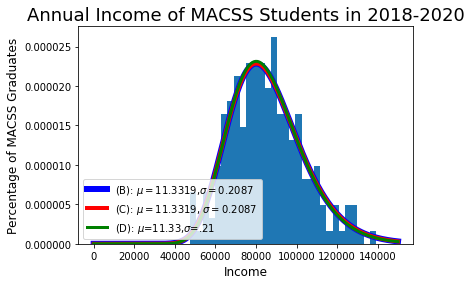

In [150]:
inc_sim = np.linspace(0.0001, 150000, 200)
plt.hist(income_macss, bins = 30, normed = True)
plt.title("Annual Income of MACSS Students in 2018-2020", fontsize=18)
plt.xlabel("Annual Income", fontsize=12)
plt.ylabel("Percentage of MACSS Graduates", fontsize=12)

plt.plot(dist_income, trunc_lognorm_pdf(dist_income, mu_GMM1, sig_GMM1, 150000),
         linewidth=6, color='blue', label='(B): $\mu = 11.3319$,$\sigma = 0.2087$')

plt.plot(dist_income, trunc_lognorm_pdf(dist_income, mu_GMM2, sig_GMM2, 150000),
         linewidth=4, color='r', label='(C): $\mu = 11.3319$, $\sigma = 0.2087$')
plt.plot(inc_sim, trunc_lognorm_pdf(inc_sim, mu_GMM1_3, sig_GMM1_3, 150000),
         linewidth=3, color = 'green', label = '(D): $\mu$=11.33,$\sigma$=.21')

plt.legend(loc = 'lower left')
plt.show()

#### 1E

Estimate Paremeters 1E

In [151]:
err1_3 = err_vec3(income, mu_GMM1_3, sig_GMM1_3, 150000, True)
VCV2_3 = np.dot(err1_3, err1_3.T) / income_macss.shape[0]
W_hat2_3 = lin.pinv(VCV2_3) 


mu_init = 11.0

sig_init = 0.5


params_init = np.array([mu_GMM1_3, sig_GMM1_3])
gmm_args2_3 = (income, 150000, W_hat2_3)
results2_3 = opt.minimize(criterion3, params_init, args=(gmm_args2_3),
                        method='TNC', bounds=((1e-10, None), (1e-10, None)))


mu_GMM2_3, sig_GMM2_3 = results2_3.x
params_init2_3 = np.array([mu_GMM2_3, sig_GMM2_3])
value_3e = criterion3(params_init2_3, *gmm_args2_3)[0][0]
data_moment3e_1, data_moment3e_2, data_moment3e_3 = data_moments3(income_macss)
model_moment3e_1, model_moment3e_2,model_moment3e_3 = model_moments3(mu_GMM2_3,
                                                             sig_GMM2_3, 150000)


print('')
print('Estimated mu with two step GMM using three moments is=', mu_GMM2_3)
print('Estimated standard deviation with two step GMM using three moments  is=', sig_GMM2_3)
print('The value of GMM criterion function at the estimated parameter values is =', value_3e)
print('Data moments at the estimated parameter values are=', data_moment3e_1, data_moment3e_2, data_moment3e_3)
print('Model moments at the estimated parameter values are=', model_moment3e_1, model_moment3e_2,model_moment3e_3)


Estimated mu with two step GMM using three moments is= 11.3750413841
Estimated standard deviation with two step GMM using three moments  is= 0.211231122253
The value of GMM criterion function at the estimated parameter values is = 8.9693994163e-13
Data moments at the estimated parameter values are= 0.3 0.5 0.2
Model moments at the estimated parameter values are= 0.23911064458138132 0.5039351508048616 0.2569542046137564


Graph 1E

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in multiply
  


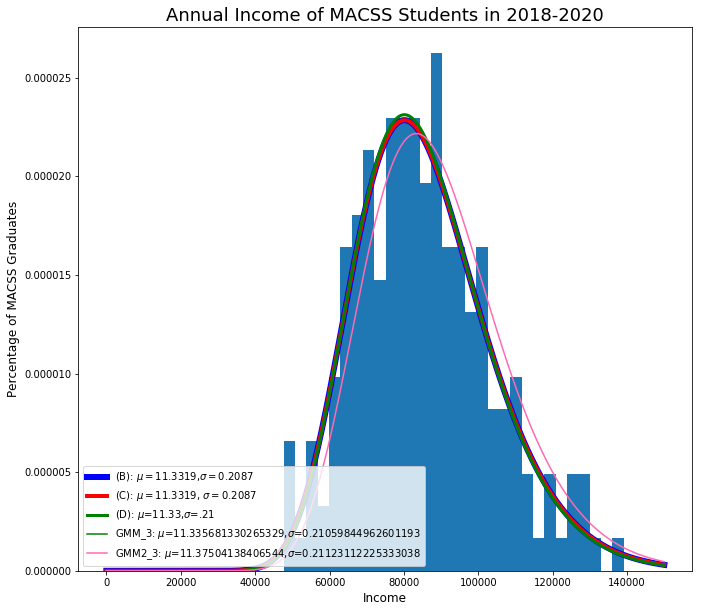

In [152]:
plt.figure(figsize=(11,10))
inc_sim = np.linspace(0.0001, 150000, 200)
plt.hist(income_macss, bins = 30, normed = True)

# Incorporate all old estimates with new estimates
plt.title("Annual Income of MACSS Students in 2018-2020", fontsize=18)
plt.xlabel("Annual Income", fontsize=12)
plt.ylabel("Percentage of MACSS Graduates", fontsize=12)
plt.plot(dist_income, trunc_lognorm_pdf(dist_income, mu_GMM1, sig_GMM1, 150000),
         linewidth=6, color='blue', label='(B): $\mu = 11.3319$,$\sigma = 0.2087$')
plt.plot(dist_income, trunc_lognorm_pdf(dist_income, mu_GMM2, sig_GMM2, 150000),
         linewidth=4, color='r', label='(C): $\mu = 11.3319$, $\sigma = 0.2087$')
plt.plot(inc_sim, trunc_lognorm_pdf(inc_sim, mu_GMM1_3, sig_GMM1_3, 150000),
         linewidth=3, color = 'green', label = '(D): $\mu$=11.33,$\sigma$=.21')
plt.plot(inc_sim, trunc_lognorm_pdf(inc_sim, mu_GMM1_3, sig_GMM1_3, 150000), color = 'green', label = 'GMM_3: $\mu$={},$\sigma$={}'.format(mu_GMM1_3, sig_GMM1_3))
plt.plot(inc_sim, trunc_lognorm_pdf(inc_sim, mu_GMM2_3, sig_GMM2_3, 150000), color = 'hotpink', label = 'GMM2_3: $\mu$={},$\sigma$={}'.format(mu_GMM2_3, sig_GMM2_3))

plt.legend(loc = 'lower left')
plt.show()

#### 1F

##### All four estimations were extremely similar, however I would choose choice E as the most representative. While the other estimations cover the bulk of the data well, they dont account as well for the slight right tail. However this is just from observing the graph. That said, the criterion value was lowest for option D, indicating that it would actually be the strongest estimator.

#### Problem 2

In [153]:
sick = np.loadtxt('sick.txt', skiprows=1, delimiter=',')



def sick_data_moments(data):
    data_momentsls = []
    for i in range(data.shape[0]):
        data_value = data[i,0]
        data_momentsls.append(data_value)
    return data_momentsls



def sick_model_moments(data, b0, b1, b2, b3):
    model_momentsls = []
    for i in range(data.shape[0]):
        age_i = data[i,1]
        children_i= data[i,2]
        avgtemp_winter_i = data[i,3]
        model_value = b0 + b1 * age_i + b2 * children_i + b3 * avgtemp_winter_i
        model_momentsls.append(model_value)
    return model_momentsls



def sick_err_vec(data, b0, b1, b2, b3):
    sick_values = sick_data_moments(data)
    moms_data = np.array(sick_values)
    expected_values = sick_model_moments(data, b0, b1, b2, b3)
    moms_model = np.array(expected_values)
    err_vec = moms_model - moms_data
    return err_vec



def sick_criterion(params, *args):
    b0,b1,b2,b3 = params
    data, sick_cutoff, W = args
    err = sick_err_vec(data, b0, b1, b2, b3)
    crit_val = np.dot(np.dot(err.T, W), err) 
    return crit_val



b0_init, b1_init, b2_init, b3_init = (0.2, 0.2, 0.3, 0.3)


# Establish minimizer
sick_params_init = np.array([b0_init,b1_init,b2_init,b3_init])
sick_bnds = ((None, None),(None, None), (None, None), (None, None))
sick_W_hat = np.eye(200)
sick_args = (sick, np.inf, sick_W_hat) 
sick_results = opt.minimize(sick_criterion, sick_params_init, args=(sick_args),
                       method='L-BFGS-B', bounds=sick_bnds)


b0_GMM, b1_GMM, b2_GMM, b3_GMM = sick_results.x

sick_params_init = np.array([b0_GMM, b1_GMM, b2_GMM, b3_GMM])
value_sick = sick_criterion(sick_params_init, *sick_args)

print('') 
print("My parameter estimates are (in order):" , b0_GMM, b1_GMM, b2_GMM, b3_GMM)
print("My criterion value is : ", value_sick )


My parameter estimates are (in order): 0.251644736076 0.0129334509219 0.400501175398 -0.00999169555811
My criterion value is :  0.00182128981703
